<a href="https://colab.research.google.com/github/ShesterG/Twitter-Sentiment-Analysis/blob/master/notebooks/13_smv_model_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM with Smote Model for Twitter Sentiment Analysis

This model will use SVM with tf/idf to classify the tweets.

It will reduce the dimensionality of the feature set by adjusting the minimum document frequency of words, in an attempt to get better results.

It will use SMOTE to synthesize some data to balance the classes.

It will use Lemmatization to reduce dimensionality

# Imports and Constants

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
#import evaluation_functions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import ast

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
DATA_FILE_PATH = '/content/drive/MyDrive/NLPGh/'
CLEAN_DATA_FILE_NAME = 'DataSet2Clean.csv'
TOKENIZED_DATA_FILE_NAME = 'DataSet2Tokenized.csv'
pd.set_option('display.max_colwidth', None)
RANDOM_STATE = 42

# Load Data

In [4]:
df = pd.read_csv(DATA_FILE_PATH + TOKENIZED_DATA_FILE_NAME)

In [5]:
df.head()

,Unnamed,tweet,location,pretweet,Sentiment,tokens
0,65780,Pls add us some momo to make data 0246964913 ðŸ˜‚ðŸ˜‚ðŸ˜‚ https://t.co/w5ozYUF59x,NaN,pl add some momo make data,0.0,"['pl', 'add', 'some', 'momo', 'make', 'data']"
1,65781,@McVan_1 @AnnanPerry @blac4rina We will descend on @NAkufoAddo soon,Ghana,will descend soon,0.0,"['will', 'descend', 'soon']"
2,65782,*Forgery allegations by EC is not enough to disqualify the five presidential candidates*\n\nhttps://t.co/GAkYghEbQHâ€¦ https://t.co/o0pCodbuWj,NaN,forgeri alleg not enough disqualifi the five presidenti candid,0.0,"['forgeri', 'alleg', 'not', 'enough', 'disqualifi', 'the', 'five', 'presidenti', 'candid']"
3,65783,@NiiWills @bosompemny I donâ€™t know how dem dey see @NAkufoAddo oo,dansoman accra,dont know how dem dey see,0.0,"['dont', 'know', 'how', 'dem', 'dey', 'see']"
4,65784,Do we have online renewal what what ka kwano?? https://t.co/3CdekJYMgr,Botswana,have onlin renew what what kwano,0.0,"['have', 'onlin', 'renew', 'what', 'what', 'kwano']"


In [6]:
# convert list of strings represented as a string to a list of strings
df.tokens = df.tokens.map(ast.literal_eval)

In [9]:
data = df[['tokens', 'Sentiment']]

In [10]:
data.head()

,tokens,Sentiment
0,"[pl, add, some, momo, make, data]",0.0
1,"[will, descend, soon]",0.0
2,"[forgeri, alleg, not, enough, disqualifi, the, five, presidenti, candid]",0.0
3,"[dont, know, how, dem, dey, see]",0.0
4,"[have, onlin, renew, what, what, kwano]",0.0


# Split Data

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], 
                                                    data['Sentiment'],
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = data['Sentiment'])

In [12]:
X_train.shape

(1637,)

In [13]:
X_test.shape

(410,)

# Encode Labels

In [14]:
le = LabelEncoder()

In [15]:
y_train_enc = le.fit_transform(y_train)

In [16]:
y_test_enc = le.transform(y_test)

# Evaluate Adjustments to Minimum Document Frequency

In [17]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer:
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in doc]

In [18]:
def passthrough(doc):
    """passthrough function for use in the pipeline because the text is already tokenized"""
    return doc

In [25]:
def train_and_eval_model(min_df):
    """
    Train and Evaluate and Bag of Words Representation with a SVM
    classifier with a specified minimum document frequency.
    """
    
    pipeline = Pipeline([('bow',CountVectorizer(min_df=min_df, 
                                                preprocessor=passthrough, 
                                                tokenizer=LemmaTokenizer())),
                         ('tfidf', TfidfTransformer()),
                         ('smote', SMOTE(random_state=RANDOM_STATE, 
                                         n_jobs=-1)),
                         ('SVM', SVC(kernel = 'linear', probability = True, random_state = RANDOM_STATE))])
    
    pipeline.fit(X_train,y_train_enc)
    
    print(f'MINIMUM DOCUMENT FREQUENCY = {min_df}')
    print('')
    

    y_pred = pipeline.predict(X_test)



    conf_matrix = confusion_matrix(y_true=y_test_enc, y_pred=y_pred)
    #confusion_matrix(y_true=y_train_enc, y_pred=pipeline.predict(X_train),labels='Training')

    
    classi_report = classification_report(y_true=y_test_enc, y_pred=y_pred, target_names=['Negative', 'Neutral', 'Postive'])
    print(classi_report)


    
    train_accuracy = accuracy_score(y_train_enc, pipeline.predict(X_train))
    
    test_accuracy = accuracy_score(y_test_enc, pipeline.predict(X_test))
    
    ave_macro_recall = recall_score(y_test_enc, pipeline.predict(X_test), average='macro')
    recall_scores = recall_score(y_test_enc, pipeline.predict(X_test), average=None)
    
    test_results = np.append(np.array([min_df, train_accuracy, test_accuracy, ave_macro_recall]),
                             recall_scores)
   
    return test_results, conf_matrix
    

In [28]:
metrics_summary = []

for min_df in range(1,11):
    test_scores, conf_matrix = train_and_eval_model(min_df)
    metrics_summary.append(test_scores)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 1

              precision    recall  f1-score   support

    Negative       0.40      0.18      0.25        11
     Neutral       0.95      0.98      0.97       356
     Postive       0.79      0.72      0.76        43

    accuracy                           0.93       410
   macro avg       0.72      0.63      0.66       410
weighted avg       0.92      0.93      0.93       410



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 2

              precision    recall  f1-score   support

    Negative       0.19      0.36      0.25        11
     Neutral       0.95      0.87      0.91       356
     Postive       0.52      0.77      0.62        43

    accuracy                           0.85       410
   macro avg       0.55      0.67      0.59       410
weighted avg       0.89      0.85      0.86       410



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 3

              precision    recall  f1-score   support

    Negative       0.10      0.27      0.15        11
     Neutral       0.95      0.85      0.89       356
     Postive       0.48      0.72      0.58        43

    accuracy                           0.82       410
   macro avg       0.51      0.61      0.54       410
weighted avg       0.88      0.82      0.84       410



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 4

              precision    recall  f1-score   support

    Negative       0.12      0.36      0.18        11
     Neutral       0.95      0.82      0.88       356
     Postive       0.47      0.74      0.58        43

    accuracy                           0.80       410
   macro avg       0.51      0.64      0.55       410
weighted avg       0.88      0.80      0.83       410



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 5

              precision    recall  f1-score   support

    Negative       0.11      0.36      0.16        11
     Neutral       0.95      0.81      0.87       356
     Postive       0.45      0.74      0.56        43

    accuracy                           0.79       410
   macro avg       0.50      0.64      0.53       410
weighted avg       0.88      0.79      0.82       410



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 6

              precision    recall  f1-score   support

    Negative       0.07      0.27      0.12        11
     Neutral       0.96      0.78      0.86       356
     Postive       0.42      0.79      0.55        43

    accuracy                           0.76       410
   macro avg       0.48      0.61      0.51       410
weighted avg       0.88      0.76      0.80       410



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 7

              precision    recall  f1-score   support

    Negative       0.06      0.27      0.10        11
     Neutral       0.96      0.75      0.84       356
     Postive       0.40      0.79      0.54        43

    accuracy                           0.74       410
   macro avg       0.47      0.60      0.49       410
weighted avg       0.87      0.74      0.79       410



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 8

              precision    recall  f1-score   support

    Negative       0.06      0.27      0.10        11
     Neutral       0.96      0.74      0.84       356
     Postive       0.41      0.79      0.54        43

    accuracy                           0.74       410
   macro avg       0.48      0.60      0.49       410
weighted avg       0.88      0.74      0.79       410



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 9

              precision    recall  f1-score   support

    Negative       0.05      0.27      0.09        11
     Neutral       0.96      0.72      0.82       356
     Postive       0.39      0.77      0.52        43

    accuracy                           0.71       410
   macro avg       0.47      0.59      0.47       410
weighted avg       0.87      0.71      0.77       410



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 10

              precision    recall  f1-score   support

    Negative       0.05      0.27      0.08        11
     Neutral       0.96      0.72      0.82       356
     Postive       0.40      0.77      0.53        43

    accuracy                           0.71       410
   macro avg       0.47      0.59      0.48       410
weighted avg       0.88      0.71      0.77       410



In [30]:
metrics_summary_df = pd.DataFrame(metrics_summary, 
                                  columns=['min doc freq',
                                           'train accuracy',
                                           'test accuracy',
                                           'macro recall',
                                          'neg recall',
                                          'neutral recall',
                                          'pos recall'])

metrics_summary_df

,min doc freq,train accuracy,test accuracy,macro recall,neg recall,neutral recall,pos recall
0,1.0,0.987172,0.931707,0.627695,0.181818,0.980337,0.720930
1,2.0,0.949908,0.846341,0.667288,0.363636,0.870787,0.767442
2,3.0,0.931582,0.817073,0.613054,0.272727,0.845506,0.720930
3,4.0,0.909591,0.802439,0.643619,0.363636,0.823034,0.744186
4,5.0,0.895541,0.787805,0.638001,0.363636,0.806180,0.744186
5,6.0,0.874771,0.763415,0.612902,0.272727,0.775281,0.790698
6,7.0,0.859499,0.739024,0.603539,0.272727,0.747191,0.790698
7,8.0,0.840562,0.736585,0.602602,0.272727,0.744382,0.790698
8,9.0,0.827123,0.709756,0.585487,0.272727,0.716292,0.767442
9,10.0,0.817960,0.714634,0.587360,0.272727,0.721910,0.767442


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


MINIMUM DOCUMENT FREQUENCY = 2

              precision    recall  f1-score   support

    Negative       0.19      0.36      0.25        11
     Neutral       0.95      0.87      0.91       356
     Postive       0.52      0.77      0.62        43

    accuracy                           0.85       410
   macro avg       0.55      0.67      0.59       410
weighted avg       0.89      0.85      0.86       410



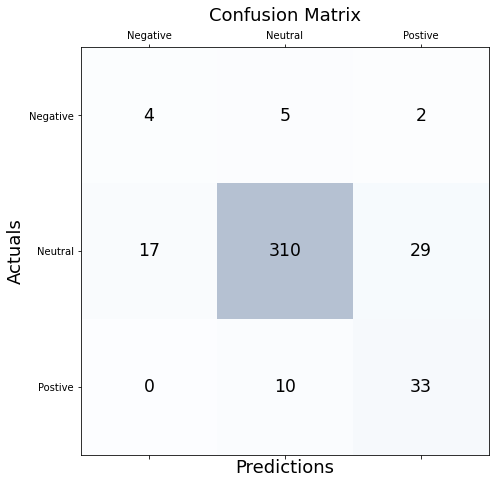

In [31]:
_,conf_matrix = train_and_eval_model(min_df=2)
labels = ['Negative', 'Neutral', 'Postive']

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Summary

The addition of lemmatization resulted in not a very different performance compared to the SVM model with just SMOTE oversampling.